# MLPC on double pyrogen samples


MLPC model performance using the data from samples that contained double pyrogens.

Reset

In [ ]:
# %reset -f

Imports

In [1]:
import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics

Initialising dictionary for statistics

In [2]:
statistics_dict = {}

Functions

In [71]:
def load_data(path, metadata, reads_list):
    all_metadata = pd.read_csv(
        os.path.join(path, f"{metadata}.csv"),
        index_col="index",
        encoding="utf8",
        sep=";",
    )

    metadata = list(
        all_metadata[
            ((all_metadata["include_in_model"] == True))
            & (all_metadata["exclude_from_model"] == False)
        ].index
    )

    raw_reads_df = pd.DataFrame()
    for filename in filenamelist:
        temp_df = pd.read_csv(
            os.path.join(path, filename), encoding="utf8", index_col="gene"
        )
        raw_reads_df = raw_reads_df.join(temp_df, how="right")

    raw_reads_df.reset_index(inplace=True, drop=False)

    # Makes sample names uniform
    new_columns = ("&").join(list(raw_reads_df.columns))
    new_columns = new_columns.replace("control", "IMDM")
    new_columns = new_columns.replace("CL307", "CL-307")
    new_columns = new_columns.replace("Albu", "AH1252")
    new_columns = new_columns.replace("cAlb", "AH1397")
    new_columns = new_columns.replace("Alb2", "AH1405")
    new_columns = new_columns.replace("LPS_PGN", "LPS-PGN")
    new_columns = new_columns.replace("LPS_R848", "LPS-R848")
    new_columns = new_columns.replace("Pam3_PGN", "Pam3-PGN")
    new_columns = new_columns.replace("Pam3_R848", "Pam3-R848")
    new_columns = new_columns.replace("PAM3", "Pam3")
    new_columns = new_columns.replace("Fla-ST", "Fla-St")
    new_columns = new_columns.replace("TL8", "TL8-506")
    new_columns = new_columns.replace("CL8", "TL8-506")

    new_columns = new_columns.split("&")
    raw_reads_df.columns = new_columns

    included_raw_reads = raw_reads_df[metadata].copy()
    included_raw_reads["gene"] = raw_reads_df["gene"]
    sample_name_list = get_pyrogen_name(set(included_raw_reads.columns[:-1]))
    print("current samples:", list(set(sample_name_list)))

    return raw_reads_df[metadata].copy()


def filter_out_lower_than_10_reads(counts):
    # Calculate the mean count for each gene (row)
    mean_counts = counts.mean(axis=1)

    # Filter out rows where mean count is greater than 10
    filtered = counts[mean_counts >= 10]

    return filtered


def to_normalize_DESeq2_style(data):
    # Ensure all values are non-negative
    data = data.applymap(lambda x: max(x, 0))

    # Take the log
    log_data = np.log1p(data)

    # Calculate the pseudo-reference sample for each gene
    log_data["pseudo_reference"] = log_data.mean(axis=1)

    # Filter out genes with -Inf as their average
    filtered_log_data = log_data[log_data["pseudo_reference"] != float("-inf")]

    # Subtract the gene pseudo-references from log counts
    ratio_data = filtered_log_data.iloc[:, :-1].sub(
        filtered_log_data["pseudo_reference"], axis=0
    )

    # Find the median of the ratios for each sample
    sample_medians = ratio_data.median(axis=0)

    # Convert medians to scaling factors
    scaling_factors = np.exp(sample_medians)

    # Divide the original counts by the scaling factors
    manually_normalized = data.div(scaling_factors)

    return manually_normalized


def get_pyrogen_name(sample_name_list):
    output = []
    for sample in sample_name_list:
        output.append(sample.split("_")[1])
    return output


def raw_to_rpm(DataFrame):
    outputDF = pd.DataFrame()
    for sample in DataFrame.columns:
        total_reads = DataFrame[sample].sum()
        outputDF[sample] = DataFrame[sample].apply(
            lambda x: (x / total_reads) * 1000000
        )
    return outputDF


def plot_PCA(data, title):
    # determines samplenames
    hue = []
    style = []
    for sample in data.columns:
        sample = sample.split("_")
        hue.append(sample[1])
        style.append(sample[0])

    testDF = data.transpose()
    pca = PCA(n_components=2)
    principalcomponents = pca.fit_transform(testDF)
    outputDF = pd.DataFrame(
        principalcomponents, columns=["PC0", "PC1"], index=data.columns
    )
    loadings = pd.DataFrame(
        pca.components_.transpose(), columns=["PC0", "PC1"], index=data.index
    )

    a = sns.scatterplot("PC0", "PC1", data=outputDF, hue=hue, style=style)

    a.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)
    a.set_title(title)
    # print(pca.explained_variance_ratio_)
    return ()


# Accuracy: (True Positive + True Negative) / Total Predictions
# Precision: True Positive / (True Positive + False Positive)
# Recall: True Positive / (True Positive + False Negative)
# Specificity: True Negative / (True Negative + False Positive)
# F-score: 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))


def evaluate_model(name, real_labels, predicted_labels):
    accuracy, precision, recall, specificity, f1_score, confusion_matrix = (
        metrics.accuracy_score(real_labels, predicted_labels),
        metrics.precision_score(
            real_labels, predicted_labels, average="macro", zero_division=0
        ),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.recall_score(real_labels, predicted_labels, average="macro"),
        metrics.f1_score(real_labels, predicted_labels, average="macro"),
        metrics.confusion_matrix(real_labels, predicted_labels),
    )
    statistics_dict[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1_score,
        "Confusion Matrix": confusion_matrix,
    }
    return statistics_dict

In [72]:
file_name_list = [
    "BA034_raw_reads.csv",
    "BA044_raw_reads.csv",
    "BA051_raw_reads.csv",
    "BA061_raw_reads.csv",
    "BA064_raw_reads.csv",
]

# loads all seq datasets
path = "~/MATseq/library/ML_models/double pyrogens with no IMDM/support_files"


# loads metadata
train_set = load_data(path=path, metadata="all_metadata", reads_list=file_name_list)
test_set = load_data(
    path=path, metadata="double_pyr_metadata", reads_list=file_name_list
)

current samples: ['Pam3', 'PGN', 'LTA', 'R848', 'Fla-PA', 'CL-307', 'CRX-527']
current samples: ['Pam3-R848', 'Pam3-PGN', 'LPS-R848', 'LPS-PGN']


In [ ]:
# loads metadata
all_metadata = pd.read_csv(
    os.path.join(path, "double_pyr_metadata.csv"),
    encoding="utf8",
    sep=";",
    index_col="index",
)

metadata = list(
    all_metadata[
        ((all_metadata["include_in_model"] == True))
        & (all_metadata["exclude_from_model"] == False)
    ].index
)

raw_reads_df = pd.DataFrame()
for filename in filenamelist:
    temp_df = pd.read_csv(
        os.path.join(path, filename), encoding="utf8", index_col="gene"
    )
    raw_reads_df = raw_reads_df.join(temp_df, how="right")

raw_reads_df.reset_index(inplace=True, drop=False)

# make sample names uniform
new_columns = ("&").join(list(raw_reads_df.columns))

new_columns = new_columns.replace("control", "IMDM")
new_columns = new_columns.replace("CL307", "CL-307")
new_columns = new_columns.replace("Albu", "AH1252")
new_columns = new_columns.replace("cAlb", "AH1397")
new_columns = new_columns.replace("Alb2", "AH1405")
new_columns = new_columns.replace("LPS_PGN", "LPS-PGN")
new_columns = new_columns.replace("LPS_R848", "LPS-R848")
new_columns = new_columns.replace("Pam3_PGN", "Pam3-PGN")
new_columns = new_columns.replace("Pam3_R848", "Pam3-R848")
new_columns = new_columns.replace("PAM3", "Pam3")
new_columns = new_columns.replace("Fla-ST", "Fla-St")
new_columns = new_columns.replace("TL8", "TL8-506")
new_columns = new_columns.replace("CL8", "TL8-506")

new_columns = new_columns.split("&")
raw_reads_df.columns = new_columns

included_raw_reads = raw_reads_df[metadata].copy()
# included_raw_reads["gene"] = raw_reads_df["gene"]


# sample_name_list = get_pyrogen_name(set(included_raw_reads.columns[:-1]))

# print("current samples:", list(set(sample_name_list)))

DESeq2 normalisation and filtration of more than 10 reads mean per gene, then zscore standardization

In [78]:
from scipy.stats import zscore as zscore

norm_train_set = to_normalize_DESeq2_style(train_set)
norm_filt_train_set = filter_out_lower_than_10_reads(norm_train_set)
z_train_set = zscore(norm_filt_train_set)

# norm_test_set = to_normalize_DESeq2_style(test_set)
# norm_filt_test_set = filter_out_lower_than_10_reads(norm_test_set)
# z_test_set = zscore(norm_filt_test_set)

norm_test_set = test_set.loc[norm_filt_train_set.index]
z_test_set = zscore(norm_test_set)

Training the model

In [79]:
real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set]

y = pd.Series(real_labels, index=z_train_set.T.index)
X = z_train_set.T

# Define the best parameters
params = {
    "activation": "relu",
    "alpha": 0.0001,
    "batch_size": "auto",
    "beta_1": 0.9,
    "beta_2": 0.999,
    "early_stopping": False,
    "epsilon": 1e-08,
    "hidden_layer_sizes": (100,),
    "learning_rate": "constant",
    "learning_rate_init": 0.001,
    "max_fun": 15000,
    "max_iter": 600,
    "momentum": 0.9,
    "n_iter_no_change": 10,
    "nesterovs_momentum": True,
    "power_t": 0.5,
    "random_state": 0,
    "shuffle": True,
    "solver": "adam",
    "tol": 0.0001,
    "validation_fraction": 0.1,
    "verbose": False,
    "warm_start": False,
}

# Create the MLPClassifier with the best parameters
mlpc = MLPClassifier(**params)

# # Fit the classifier to your data (X_train and y_train)
# mlpc.fit(X, y)

Checking perfromace of the trained model

In [80]:
real_labels = [("_").join(i.split("_")[1:2]) for i in z_train_set]

y = pd.Series(real_labels, index=z_train_set.T.index)
X = z_train_set.T


loo = LeaveOneOut()
predicted_labels = []

for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create and train the MLPC classifier
    model = mlpc
    model.fit(X_train, y_train)

    # Make predictions on the test fold
    y_pred = model.predict(X_test)
    predicted_labels.append(y_pred[0])  # Append the predicted label for this fold

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34] TEST: [7]
TRAIN: [ 0  1  2  3  4  

In [76]:
name = "MLPC no IMDM no LPS"
mlps_performance = evaluate_model(name, real_labels, predicted_labels)

Model: MLPC no IMDM train set
Accuracy: 0.9591836734693877
Precision: 0.984375
Recall: 0.9166666666666666
Specificity: 0.9166666666666666
F1 Score: 0.9291666666666667
Confusion Matrix: [[ 6  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0]
 [ 0  0  1  2  0  0  0  0]
 [ 0  0  0 14  0  0  0  0]
 [ 0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  5]]
Model: MLPC no IMDM 7 LPS train set
Accuracy: 0.9761904761904762
Precision: 0.984375
Recall: 0.9583333333333333
Specificity: 0.9583333333333333
F1 Score: 0.9666666666666667
Confusion Matrix: [[6 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0]
 [0 0 2 1 0 0 0 0]
 [0 0 0 7 0 0 0 0]
 [0 0 0 0 3 0 0 0]
 [0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 5]]
Model: MLPC no IMDM no LPS
Accuracy: 0.9761904761904762
Precision: 0.984375
Recall: 0.9583333333333333
Specificity: 0.9583333333333333
F1 Score: 0.9666666666666667
Confusion Matrix: [[6 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0]
 [0 0 2 1 0 0 0 0]
 [0 0 0 7 0 0 0

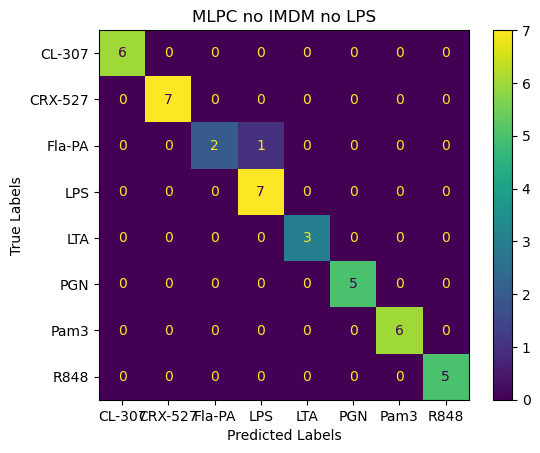

In [77]:
for model, model_stats in statistics_dict.items():
    print(f"Model: {model}")
    for metric, value in model_stats.items():
        print(f"{metric}: {value}")

    # class_labels = y.unique()
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=statistics_dict[model]["Confusion Matrix"],
        display_labels=mlpc.classes_,
    )

cm_display.plot()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"{model}")
plt.show()

Testing model on the double pyrogen samples

In [67]:
real_labels = [("_").join(i.split("_")[1:2]) for i in z_test_set]

# Create a new DataFrame with the original index as a column
y = pd.Series(real_labels, index=z_test_set.T.index)
X = z_test_set.T

predicted_labels = mlpc.predict(X)

In [68]:
df_summary = pd.DataFrame()
df_summary["real labels"] = y
df_summary["predicted labels"] = predicted_labels
df_summary

,real labels,predicted labels
BA060_LPS-PGN_13,LPS-PGN,LPS
BA060_LPS-PGN_14,LPS-PGN,LPS
BA060_LPS-PGN_15,LPS-PGN,LPS
BA060_LPS-PGN_16,LPS-PGN,LPS
BA060_LPS-R848_17,LPS-R848,R848
BA060_LPS-R848_18,LPS-R848,R848
BA060_LPS-R848_19,LPS-R848,R848
BA060_Pam3-PGN_5,Pam3-PGN,LPS
BA060_Pam3-PGN_6,Pam3-PGN,LPS
BA060_Pam3-PGN_7,Pam3-PGN,LPS
